In [1]:
# hydrological packages
import hydroeval as he
from hydrotools.nwm_client import utils 

# basic packages
import numpy as np
import pandas as pd
import os
import pyarrow as pa
import pyarrow.parquet as pq
import bz2file as bz2

# system packages
from progressbar import ProgressBar
from datetime import datetime, date
import datetime
import pickle as pkl
import warnings
warnings.filterwarnings("ignore")
import platform
import time

# data analysi packages
from scipy import optimize
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import joblib

# deep learning packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#Shared/Utility scripts
import sys
import boto3
import s3fs
sys.path.insert(0, '../..') #sys allows for the .ipynb file to connect to the shared folder files
from shared_scripts import Simple_Eval

#load access key
HOME = os.path.expanduser('~')
KEYPATH = "NWM_ML/AWSaccessKeys.csv"
ACCESS = pd.read_csv(f"{HOME}/{KEYPATH}")

#start session
SESSION = boto3.Session(
    aws_access_key_id=ACCESS['Access key ID'][0],
    aws_secret_access_key=ACCESS['Secret access key'][0],
)
S3 = SESSION.resource('s3')
#AWS BUCKET information
BUCKET_NAME = 'streamflow-app-data'
BUCKET = S3.Bucket(BUCKET_NAME)

#s3fs
fs = s3fs.S3FileSystem(anon=False, key=ACCESS['Access key ID'][0], secret=ACCESS['Secret access key'][0])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

modelname = "MLP"

print(f"{modelname} development script")

Device: cuda
MLP development script


In [58]:
modelname = 'MLP'
model_path = f"{HOME}/NWM_ML/Model/{modelname}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

cfsday_AFday = 1.983
print(f"{modelname} development script")

#input columns
input_columns =[
                # 'Lat', 
                # 'Long', 
                'Drainage_area_mi2', 
                #'Mean_Basin_Elev_ft',       
                #'Perc_Forest', 
                'Perc_Develop', 
                'Perc_Imperv', 
                #'Perc_Herbace',       
                'Perc_Slop_30', 
                #'Mean_Ann_Precip_in', 
                's1',       
                's2', 
                'storage', 
                'swe', # this needs to be redone for catchments, Using in american fork and there is no SWE observations and there should be!
                'NWM_flow', 
                'DOY', 
                # 'tempe(F)', 
                # 'precip(mm)'
                ]

target = 'flow_cfs'

scalername_x = "scaler_x.save"
scalername_y = "scaler_y.save"
x_scaler_path = f"{model_path}/{scalername_x}"
y_scaler_path = f"{model_path}/{scalername_y}"

test_years = [2020]

#headwater stations for removeal
# headwater_stations = ['10011500', # Bear River headwaters before WY state line
#                       '10109000', # Logan River above dams
#                       '10113500', # HW Blacksmith fork
#                       '10128500', # Upper Weber above Oakley
#                       '10131000', #Chalk creek before Weber - lots of upstream irrigation, potentially include
#                         '10146400', #Currant Creek above Mona Reservoir - lots of upstream irrigation, potentially include
#                         '10150500', #Spanish fork after diamond fork - potentially include because of 6th water diversion CUP
#                         '10154200', #Upper Provo river after confluence of N/S forks - potentially include because of duchense tunnel water diversion CUP
#                         '10172700', #Vernon creek 2 ranges west of Utah Lake, shouldnt be included because not in GSL basin 
#                         '10172800', #Willow creek west of Gransville,  shouldnt be included because does not make it to GSL
#                           '10172952'] #Dunn creek in Raft River Range, shouldnt be included because drains to bonnevile salt flats 

headwater_stations = [
                      '10011500', # Bear River headwaters before WY state line
                      '10109000', # Logan River above dams
                      '10113500', # HW Blacksmith fork
                      '10128500', # Upper Weber above Oakley
                      '10131000', #Chalk creek before Weber - lots of upstream irrigation, potentially include
                      '10146400', #Currant Creek above Mona Reservoir - lots of upstream irrigation, potentially include
                      '10150500', #Spanish fork after diamond fork - potentially include because of 6th water diversion CUP
                      '10154200', #Upper Provo river after confluence of N/S forks - potentially include because of duchense tunnel water diversion CUP
                      '10172700', #Vernon creek 2 ranges west of Utah Lake, shouldnt be included because not in GSL basin 
                      '10172800', #Willow creek west of Gransville,  shouldnt be included because does not make it to GSL
                      '10172952',#Dunn creek in Raft River Range, shouldnt be included because drains to bonnevile salt flats 
                      '10164500', # American fork by powerplant, removing for now because now swe or upstream storage, which it should because it has two reservoirs upstream

                      '10105900', #no swe or storage!!!!!
                      #'10126000',  #have swe and storage
                      '10129900',  #no swe or storage!!!!!
                      '10133650', #no swe or storage!!!!!
                      '10133800', #no swe or storage!!!!!
                      '10133980', #no swe or storage!!!!!
                       #'10134500',      #have swe and storage 
                      #'10136500', #have swe and storage
                      '10137500', #no swe or storage!!!!!
                      '10140100', #no swe or storage!!!!!
                      #'10140700', #have swe and storage
                      #'10141000',     #have swe and storage  
                      '10145400', #no swe or storage!!!!!
                      '10149000', #no swe or storage!!!!!
                      '10153100',#no swe or storage!!!!!
                      '10155000', #no swe or storage!!!!!
                      #'10155200', #have swe and storage
                      '10157500', #no swe or storage!!!!!
       ] 


#The following sites have swe 

'''
['10011500', '10105900', '10109000', '10126000', '10131000',
       '10133650', '10133800', '10133980', '10134500', '10136500',
       '10140700', '10141000', '10150500', '10154200', '10155000',
       '10155200']
'''

#the following sites have swe and storage
'''
['10126000', '10134500', '10136500', '10140700', '10141000',
       '10155200']
'''
                          

pred_path = f"{HOME}/NWM_ML/Predictions/Hindcast/{modelname}/Multilocation"
file_path = f"{pred_path}/{modelname}_predictions.pkl"

Device: cuda
MLP development script


In [59]:
#Get streamstats data 
datapath = f"{HOME}/NWM_ML/Data/input"
file = "Streamstats.csv"
filepath = f"{datapath}/{file}"
try:
    StreamStats = pd.read_csv(filepath)
except:
    print("Data not found, retreiving from AWS S3")
    if not os.path.exists(datapath):
        os.makedirs(datapath, exist_ok=True)
    key = 'Streamstats/Streamstats.csv'      
    S3.meta.client.download_file(BUCKET_NAME, key,filepath)
    StreamStats = pd.read_csv(filepath)

#Get processed training data 
datapath = f"{HOME}/NWM_ML/Data/Processed"
file = "raw_training_data.parquet"  #note, this file has no swe or storage, all 0s
#file = "final_input.parquet"
filepath = f"{datapath}/{file}"
try:
    df = pd.read_parquet(filepath)
except:
    print("Data not found, retreiving from AWS S3")
    if not os.path.exists(datapath):
        os.makedirs(datapath, exist_ok=True)
    key = "NWM_ML"+datapath.split("NWM_ML",1)[1]+'/'+file       
    S3.meta.client.download_file(BUCKET_NAME, key,filepath)
    df = pd.read_parquet(filepath)

try:
    df.pop('Unnamed: 0')
except:
    print('df needs no processing')
df['station_id'] = df['station_id'].astype('str')
df.head()

,station_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
0,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-28,78.55521,-0.891007,-0.453991,0.0,1.2,55.0,301
1,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-29,98.61146,-0.891007,-0.453991,0.0,1.2,55.0,302
2,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-30,97.60208,-0.891007,-0.453991,0.0,1.1,54.0,303
3,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-31,99.33125,-0.891007,-0.453991,0.0,1.2,54.0,304
4,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-11-01,95.76354,-0.998630,0.052336,0.0,1.2,54.0,305


### Dataprocessing
* Editing the features based on the feature importance
* Remove headwater stations from dataset
* make sure dates are in datetime format

In [60]:
#remove headwater stations
df = df[~df['station_id'].isin(headwater_stations)]

#convert dates to datetime format
df.datetime = pd.to_datetime(df.datetime)

# #reset index to clean up df
df.reset_index( inplace =  True, drop = True)

df.head()

,station_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
0,10126000,41.576321,-112.100782,7040.0,6620.0,15.6,4.28,0.55,15.2,1.94,22.2,2010-10-28,1162.60410,-0.891007,-0.453991,34.071895,1.142857,1183.0,301
1,10126000,41.576321,-112.100782,7040.0,6620.0,15.6,4.28,0.55,15.2,1.94,22.2,2010-10-29,1152.39590,-0.891007,-0.453991,34.673203,1.128571,1181.0,302
2,10126000,41.576321,-112.100782,7040.0,6620.0,15.6,4.28,0.55,15.2,1.94,22.2,2010-10-30,1036.51040,-0.891007,-0.453991,35.346405,1.071429,1181.0,303
3,10126000,41.576321,-112.100782,7040.0,6620.0,15.6,4.28,0.55,15.2,1.94,22.2,2010-10-31,680.29170,-0.891007,-0.453991,36.039216,1.078571,1179.0,304
4,10126000,41.576321,-112.100782,7040.0,6620.0,15.6,4.28,0.55,15.2,1.94,22.2,2010-11-01,557.59375,-0.998630,0.052336,36.699346,1.100000,1175.0,305


In [61]:
#Select training data - testing is going to be done on 2020
x_train_temp = df[df.datetime.dt.year != 2020]
x_train_temp.pop('station_id')
x_train_temp.pop('datetime')
y_train_temp = x_train_temp[target]
x_train_temp.pop(target)
x_train_temp = x_train_temp[input_columns]

#Convert dataframe to numpy, scale, save scalers
y_train = y_train_temp.to_numpy()
x_train = x_train_temp.to_numpy()

if not os.path.exists(model_path):
    os.makedirs(model_path, exist_ok=True)

scalerfilepath_x = f"{model_path}/{scalername_x}"
scalerfilepath_y = f"{model_path}/{scalername_y}"

scaler = MinMaxScaler() #potentially change scalling...
x_train_scaled = scaler.fit_transform(x_train)
joblib.dump(scaler, scalerfilepath_x)

scaler = MinMaxScaler()
y_scaled_train = scaler.fit_transform(y_train.reshape(-1, 1))
joblib.dump(scaler, scalerfilepath_y)  
print(y_scaled_train.shape)
print(x_train_scaled.shape)

(39776, 1)
(39776, 10)


### Set up Testing year
* Select year(s) not used in training
* Convert to numpy array
* Load scaler and scale data

In [62]:
#Get water year for testing from larger dataset
x_test_temp = df[df.datetime.dt.year == 2020]
x_test_temp_1 = x_test_temp.copy()
station_index_list = x_test_temp_1['station_id']
x_test_temp_1.pop('station_id')
x_test_temp_1.pop('datetime')

#Get target variable (y) and convert to numpy arrays
y_test_temp_1 = x_test_temp_1[target]
x_test_temp_1.pop(target)
x_test_temp_1 = x_test_temp_1[input_columns]
x_test_1_np = x_test_temp_1.reset_index(drop=True).to_numpy()
y_test_1_np = y_test_temp_1.reset_index(drop=True).to_numpy()


#load scalers and scale
scalername_x = "scaler_x.save"
scalername_y = "scaler_y.save"
model_path = f"{HOME}/NWM_ML/Model/{modelname}"
scalerfilepath_x = f"{model_path}/{scalername_x}"
scalerfilepath_y = f"{model_path}/{scalername_y}"

#load scalers
scaler_x = joblib.load(scalerfilepath_x)
scaler_y = joblib.load(scalerfilepath_y)

#scale the testing data
x_test_1_scaled = scaler_x.fit_transform(x_test_1_np)
y_scaled_test_1 = scaler_y.fit_transform(y_test_1_np.reshape(-1, 1))
print(y_scaled_test_1.shape)
print(x_test_1_scaled.shape)


(1918, 1)
(1918, 10)


### Set up model training framework

In [63]:
# %% MLP
# Convert to tensor for PyTorch
x_train_scaled_t = torch.Tensor(x_train_scaled)
y_train_scaled_t = torch.Tensor(y_scaled_train)
#Make sure the tensors on are the respective device (cpu/gpu)
x_train_scaled_t = x_train_scaled_t.to(device)
y_train_scaled_t = y_train_scaled_t.to(device)


## Train the model

* randomize training data..

In [64]:
#Train the model
start_time = time.time()

# Hyperparameters
epochs = 5
batch_size = 100
learning_rate = 0.001
decay = 1e-2
validation_split = 0.2
neurons = 150
input_shape = x_train_scaled_t.shape[1]
LD1=128
LD2=128
LD3=64
LD4=64
LD5=32
LD6=16
LD7=5

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(x_train_scaled_t, y_train_scaled_t)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False ) #should this be shuffled?

# Build the model
model = nn.Sequential(
    nn.Linear(input_shape, LD1),
    nn.ReLU(),
    nn.Linear(LD1, LD2),
    nn.ReLU(),
    nn.Linear(LD2, LD3),
    nn.ReLU(),
    nn.Linear(LD3, LD4),
    nn.ReLU(),
    nn.Linear(LD4, LD5),
    nn.ReLU(),
    nn.Linear(LD5, LD6),
    nn.ReLU(),
    nn.Linear(LD6, 1)
).to(device)


# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop

for epoch in range(epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

print('finish')
print("Run Time:" + " %s seconds " % (time.time() - start_time))

#save model
if os.path.exists(model_path) == False:
    os.makedirs(model_path)
torch.save(model.state_dict(), f"{model_path}/{modelname}_model.pkl")

Epoch 1/5, Loss: 0.00313679123573066
Epoch 2/5, Loss: 0.002890843413526349
Epoch 3/5, Loss: 0.0025485246022339918
Epoch 4/5, Loss: 0.002201524416539538
Epoch 5/5, Loss: 0.001884508208714503
finish
Run Time: 4.138034343719482 seconds 


## Load the model for evaluation

In [65]:
# Build and load the model
model_path = f"{HOME}/NWM_ML/Model/{modelname}"
# Hyperparameters
epochs = 20
batch_size = 100
learning_rate = 0.001
decay = 1e-2
validation_split = 0.2
neurons = 150
input_shape = x_test_1_scaled.shape[1]
LD1=128
LD2=128
LD3=64
LD4=64
LD5=32
LD6=16
LD7=5

#device = torch.device('cpu') # for some reason had to change to cpu
models = nn.Sequential(
    nn.Linear(input_shape, LD1),
    nn.ReLU(),
    nn.Linear(LD1, LD2),
    nn.ReLU(),
    nn.Linear(LD2, LD3),
    nn.ReLU(),
    nn.Linear(LD3, LD4),
    nn.ReLU(),
    nn.Linear(LD4, LD5),
    nn.ReLU(),
    nn.Linear(LD5, LD6),
    nn.ReLU(),
    nn.Linear(LD6, 1)
).to(device)

models.load_state_dict(torch.load(f"{model_path}/{modelname}_model.pkl"))

#put the model scores into a dataframe for comparison
#Evaluation columns for prediction time series
cols = ['USGSid', 'NHDPlusid', 'NWM_rmse', f"{modelname}_rmse", 'NWM_pbias', f"{modelname}_pbias", 
        'NWM_kge', f"{modelname}__kge", 'NWM_mape',  f"{modelname}_mape"]

#Evaluation columns for accumulated supply time series
supcols = ['USGSid', 'NHDPlusid', 'NWM_rmse', f"{modelname}_rmse", 'NWM_pbias', f"{modelname}_pbias", 
        'NWM_kge', f"{modelname}__kge", 'NWM_mape',  f"{modelname}_mape", 'Obs_vol', 'NWM_vol', f"{modelname}_vol",
        'NWM_vol_err', f"{modelname}_vol_err", 'NWM_vol_Perc_diff', f"{modelname}_vol_Perc_diff"]


EvalDF = pd.DataFrame(columns = cols)
SupplyEvalDF = pd.DataFrame(columns = supcols)

# Make a prediction for each location, save as compressed pkl file, and send predictions to AWS for use in CSES

In [66]:
#get annual supply diffs
cfsday_AFday = 1.983
year = 2020


Preds_Dict = {}
for station_number in station_index_list.drop_duplicates():
  #print(station_number)
  index = station_index_list == station_number
  X_test = x_test_temp_1[index]
  X_test_scaled_t = torch.Tensor(x_test_1_scaled[index])
  X_test_scaled_t = X_test_scaled_t.to(device)
  l = len(y_test_temp_1.values)
  y_test = torch.Tensor(np.array(y_test_temp_1.values).reshape(l,1))
  y_test = y_test.to(device)

  # Evaluation
  models.eval()
  with torch.no_grad():
      predictions_scaled= models(X_test_scaled_t)

  # Invert scaling for actual
  predictions = scaler_y.inverse_transform(predictions_scaled.to('cpu').numpy())
  predictions[predictions<0] = 0

  #print('Model Predictions complete')

  predictions = pd.DataFrame(predictions, columns=[f"{modelname}_flow"])

  #save predictions, need to convert to NHDPlus reach - Need to add Datetime column and flow predictions
  #make daterange
  dates = pd.date_range(pd.to_datetime("2020-01-01"), periods=len(predictions)).strftime("%Y-%m-%d").tolist()
  predictions['Datetime'] = dates
    
  #get reach id for model eval
  nhdreach = utils.crosswalk(usgs_site_codes=station_number)
  nhdreach = nhdreach['nwm_feature_id'].iloc[0]

  #put columns in correct order
  cols = ['Datetime', f"{modelname}_flow"]
  predictions = predictions[cols]

  #save predictions to AWS so we can use CSES
  state = StreamStats['state_id'][StreamStats['NWIS_site_id'].astype(str)== station_number].values[0].lower()
  csv_key = f"{modelname}/NHD_segments_{state}.h5/{modelname[:3]}_{nhdreach}.csv"
  predictions.to_csv(f"s3://{BUCKET_NAME}/{csv_key}", index = False,  storage_options={'key': ACCESS['Access key ID'][0],
                           'secret': ACCESS['Secret access key'][0]})

  #Concat DFS and put into dictionary
  x_test_temp['nwm_feature_id'] = nhdreach
  Dfs = [predictions.reset_index(drop=True),x_test_temp[x_test_temp['station_id']==station_number].reset_index(drop=True)]
  Preds_Dict[station_number] = pd.concat(Dfs, axis=1)

  #reorganize columns
  Preds_Dict[station_number].pop('datetime')
  Preds_Dict[station_number].insert(1, f"{modelname}_flow", Preds_Dict[station_number].pop(f"{modelname}_flow"))
  Preds_Dict[station_number].insert(1, "NWM_flow", Preds_Dict[station_number].pop("NWM_flow"))
  Preds_Dict[station_number].insert(1, "flow_cfs", Preds_Dict[station_number].pop("flow_cfs"))
  Preds_Dict[station_number].insert(1, "nwm_feature_id", Preds_Dict[station_number].pop("nwm_feature_id"))
  Preds_Dict[station_number].insert(1, "station_id", Preds_Dict[station_number].pop("station_id"))

  #push data to AWS so we can use CSES
  
  
#save predictions as compressed pkl file
pred_path = f"{HOME}/NWM_ML/Predictions/Hindcast/{modelname}/{year}"
file_path = f"{pred_path}/{modelname}_predictions.pkl"
if os.path.exists(pred_path) == False:
    os.makedirs(pred_path)
with open(file_path, 'wb') as handle:
    pkl.dump(Preds_Dict, handle, protocol=pkl.HIGHEST_PROTOCOL)

USGS site: 10126000


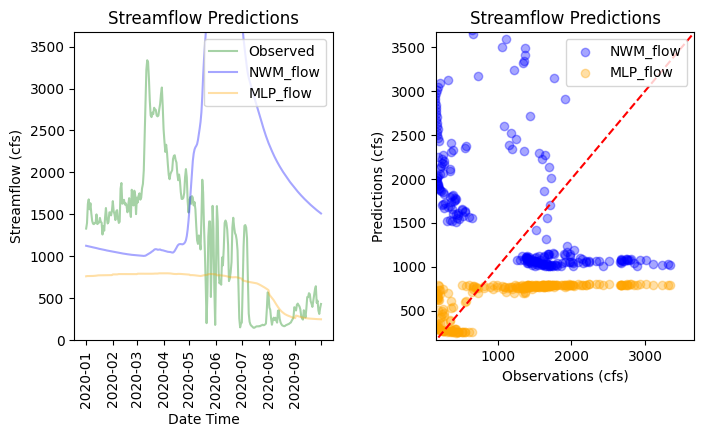

USGS site: 10134500


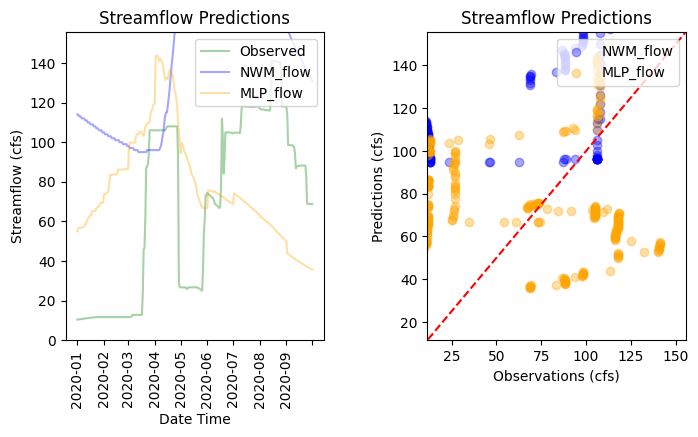

USGS site: 10136500


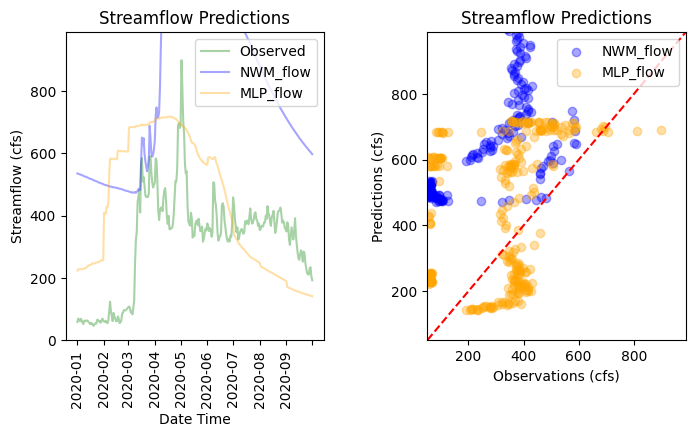

USGS site: 10140700


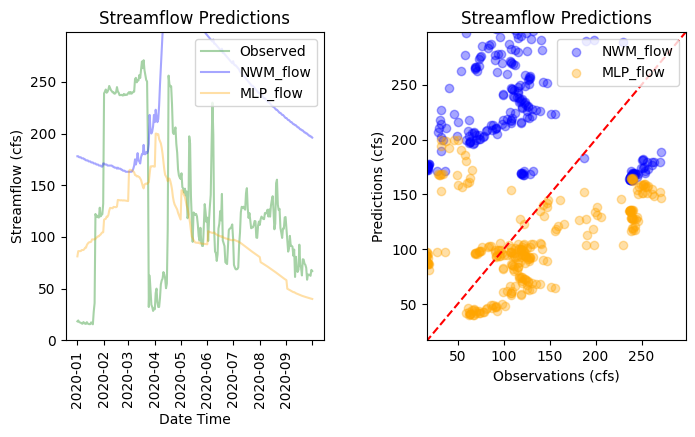

USGS site: 10141000


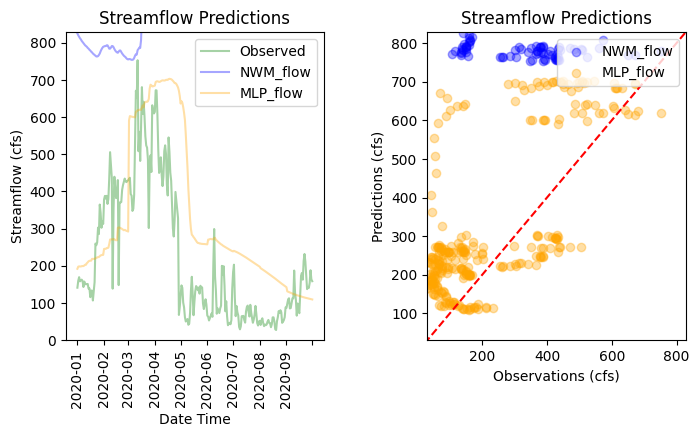

USGS site: 10155200


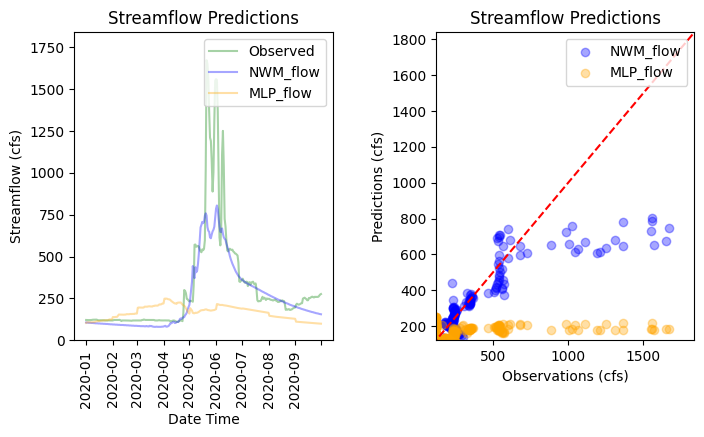

USGS site: 10171000


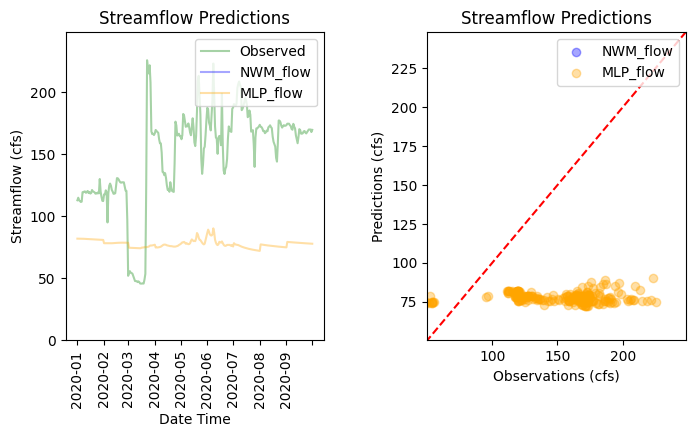

In [67]:
#Evaluate model performance of the different models, 'flow_cfs_pred', 
prediction_columns = ['NWM_flow', f"{modelname}_flow"]
Eval_DF = Simple_Eval.Simple_Eval(Preds_Dict, prediction_columns, modelname)

In [68]:
Eval_DF

,NWM_flow_kge,MLP_flow_kge,NWM_flow_rmse,MLP_flow_rmse,NWM_flow_mape,MLP_flow_mape,NWM_flow_pbias,MLP_flow_pbias,min_storage,max_storage,min_swe,max_swe,min_obs_flow,max_obs_flow,NWM_flow_flow_min,NWM_flow_flow_max,MLP_flow_flow_min,MLP_flow_flow_max
0,-4.13,0.43,1176.666054,181.135370,1141.47,145.68,-471.48,-47.84,42.555835,96.669985,0.0,18.770000,27.520370,752.92706,754.0,2088.0,109.601372,702.988586
1,-0.39,0.21,146.895499,70.414792,202.23,84.78,-84.90,17.67,38.329994,95.948120,0.0,21.550000,15.409375,270.91666,163.0,384.0,39.934067,199.915894
2,-1.33,0.18,669.746563,253.767736,285.84,152.36,-183.78,-38.84,44.246171,97.538463,0.0,18.087500,46.195160,898.41670,473.0,1656.0,141.338409,717.393127
3,-0.71,0.06,2004.216242,874.082730,368.22,71.46,-75.45,44.94,33.856209,96.470588,0.0,17.435714,147.218750,3337.70830,1005.0,5460.0,249.558838,798.057068
4,-1.01,-0.14,141.565304,54.275451,393.93,204.92,-160.24,-13.42,59.135354,98.969697,0.0,20.450000,10.400000,141.39583,95.0,386.0,35.647217,143.808426
5,0.56,-0.26,176.513067,333.413096,21.11,50.33,19.27,46.31,75.766879,99.461783,0.0,16.500000,109.958336,1672.50000,80.0,805.0,98.816566,248.547272
6,-22.90,-0.37,3387.369919,81.259737,2549.80,48.93,-2260.76,47.88,0.000000,0.000000,0.0,0.000000,45.641666,225.69792,3177.0,4812.0,72.005379,90.175385
